In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers


import os
import numpy as np

In [2]:
n=1000 # the number of terms in DP approximation (N)  !!! For high dimensional data, we need to consider n>2000
n_samplee=50
d_dim=60
y1=np.random.multivariate_normal(np.zeros(d_dim)+0, 1*np.identity(d_dim), n_samplee) # real data
#y1=np.random.standard_t(3,  (n_samplee,d_dim))
#y1=np.random.uniform(-np.sqrt(3), np.sqrt(3), (n_samplee,d_dim))
#y1=np.random.logistic(0, 1, (n_samplee,d_dim))
y2=np.random.multivariate_normal(np.zeros(d_dim), np.identity(d_dim), n) # data from distribution G
#mmd_bnp=np.zeros((18, 100))


In [3]:
from scipy import stats
from numpy.random import choice
from scipy.spatial import distance_matrix

import time
start_time = time.time()
############## DP prior (a_pri, H_pri)

#n=1000 # Determine the number of terms in DP approximation (N)
d=np.shape(y1)[1]# Determine the number of dimensions
n_sample=np.shape(y1)[0] # Determine the sample size

m=n_sample; a =25  #10000
rep=100
d_pri=np.zeros((1, rep))
d_pos=np.zeros((1, rep))
for j in range(0,rep):
    #n_samplee=1000
    #d_dim=60
    #y1=np.random.multivariate_normal(np.zeros(d_dim)+0, 1*np.identity(d_dim), n_samplee) # real data
    #y2=np.random.multivariate_normal(np.zeros(d_dim), np.identity(d_dim), n) # data from distribution G
    g1=np.zeros((1, n)); tstar1 = np.zeros((n, d))
    g21= np.zeros((1, n)); pp1= np.zeros((1, n))
    y11=np.random.exponential(scale=1.0, size=n+1)

    #np.sum(y1_1[0,0:5+1])
    #y1_1[0:10]

    for i in range(0, n):
        g1[0,i]=np.sum(y11[0:i+1])/np.sum(y11)
        g21[0,i]=stats.gamma.ppf(1-g1[0,i], a/n, 1)-1
        tstar1[i-1 ,0:d]=np.random.multivariate_normal(np.zeros(d), np.identity(d), 1) # Base measure should be the same as G
    p21=g21/np.sum(g21)
    v1=choice(np.arange(0, n, 1, dtype=int), n,p=p21[0]) 
    tstarDP1=tstar1[v1]

    Z_star1=tstarDP1; W_star1=p21
    
    X = tf.concat([y2,Z_star1], axis=0)
    XX = tf.matmul(X, tf.transpose(a=X))
    X2 = tf.reduce_sum(input_tensor=X * X, axis=1, keepdims = True)
    exponent = XX -.5*  X2 -.5* tf.transpose(a=X2)
    J2=tf.reshape(W_star1,[n,1])
    s1 =  tf.constant(1.0 / n, shape = [n, 1])
    s =tf.concat([s1,-tf.cast(J2, tf.float32)], axis=0)
    S = tf.matmul(s, tf.transpose(a=s))
    sigma =[80] #[2,5,10,20,40,80,10**2,10**4,10**6] # only sigma=1 can be considered
    loss = 0
    for i in range(len(sigma)):
        # kernel values for each combination of the rows in 'X' 
        kernel_val = tf.exp(1.0 / sigma[i] * exponent)
        loss += tf.reduce_sum(input_tensor=S * tf.cast(kernel_val,tf.float32))
    
    BNP_MMD_measure=loss  #tf.sqrt() can be used to convert MMD^2 to the MMD
    d_pri[0,j]=np.array(BNP_MMD_measure)
############## DP posterior (a_pos, H_pos)
    g1_pos=np.zeros((1, n)); tstar1_pos = np.zeros((n, d))
    g21_pos= np.zeros((1, n)); pp1_pos= np.zeros((1, n))
    y11_pos=np.random.exponential(scale=1.0, size=n+1)

    for i in range(0, n):
        g1_pos[0,i]=np.sum(y11_pos[0:i+1])/np.sum(y11_pos)
        g21_pos[0,i]=stats.gamma.ppf(1-g1_pos[0,i], (a+m)/n, 1)-1
        u=np.random.uniform(low=0.0, high=1.0, size=1)
        if u<a/(a+m):
            tstar1_pos[i-1 ,0:d]=np.random.multivariate_normal(np.zeros(d), np.identity(d), 1)
        else:
            r1=np.array(tf.random.uniform(shape=[1], minval=0, maxval=np.shape(y1)[0], dtype=tf.int64) )
            tstar1_pos[i-1 ,0:d]=y1[r1]


    p21_pos=g21_pos/np.sum(g21_pos)
    v1_pos=choice(np.arange(0, n, 1, dtype=int), n,p=p21_pos[0]) 
    tstarDP1_pos=tstar1_pos[v1_pos]

    Z_star1_pos=tstarDP1_pos; W_star1_pos=p21_pos
    
    X = tf.concat([y2,Z_star1_pos], axis=0)
    XX = tf.matmul(X, tf.transpose(a=X))
    X2 = tf.reduce_sum(input_tensor=X * X, axis=1, keepdims = True)
    exponent = XX -.5*  X2 -.5* tf.transpose(a=X2)
    J2=tf.reshape(W_star1_pos,[n,1])
    s1 =  tf.constant(1.0 / n, shape = [n, 1])
    s =tf.concat([s1,-tf.cast(J2, tf.float32)], axis=0)
    S = tf.matmul(s, tf.transpose(a=s))
    sigma =[80] #[2,5,10,20,40,80,10**2,10**4,10**6]  # only sigma=1 can be considered
    loss = 0
    for i in range(len(sigma)):
        # kernel values for each combination of the rows in 'X' 
        kernel_val = tf.exp(1.0 / sigma[i] * exponent)
        loss += tf.reduce_sum(input_tensor=S * tf.cast(kernel_val,tf.float32))
    
    BNP_MMD_measure_pos=loss  #tf.sqrt() can be used to convert MMD^2 to the MMD
    
    d_pos[0,j]=np.array(BNP_MMD_measure_pos)
    print(j)

print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
--- 358.67646741867065 seconds ---


In [4]:
##############  Relative Belief Ratio
import statsmodels.api as sm

M=20
#prior quantiles i=0,...,M
psi_prior=np.zeros((M+1, 1))
for i in range(1, M+1):
    psi_prior[i]=np.quantile(d_pri,i/M) 
psi_star=psi_prior[1]  # 1/M quantile
Fn_prior=sm.distributions.ECDF(d_pri[0]) # Fn for prior distance
Fn_post=sm.distributions.ECDF(d_pos[0]) #Fn for posterior distance
RB_dist=Fn_post(psi_star)/Fn_prior(psi_star)

############  Strength
RBR_hat=np.zeros((M, 1))
for i in range(0, M):
    RBR_hat[i]=M*(Fn_post(psi_prior[i+1])-Fn_post(psi_prior[i]))
sum0=np.zeros((M, 1))
for i in range(0, M):
    if RBR_hat[i]<=RB_dist:
        sum0[i]=Fn_post(psi_prior[i+1])-Fn_post(psi_prior[i])
strength=np.sum(sum0)

out={"RB": RB_dist[0], "strength": strength}
for k, v in out.items():
    print(k, v, sep=" = ")
psi_star

RB = 17.0
strength = 1.0


array([0.0250944])

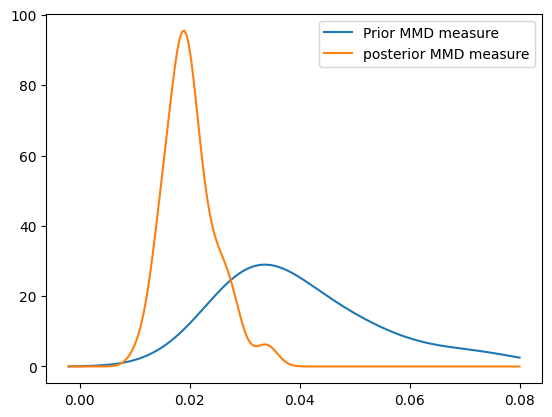

In [5]:
from scipy.stats import gaussian_kde
 

density = gaussian_kde(d_pri)
density1 = gaussian_kde(d_pos)
 
x_vals = np.linspace(-.002,.08,200) # Specifying the limits of our data
density.covariance_factor = lambda : .5 #Smoothing parameter
 
density._compute_covariance()
fig, ax = plt.subplots()
ax.plot(x_vals,density(x_vals), label="Prior MMD measure")
ax.plot(x_vals,density1(x_vals), label="posterior MMD measure")
#plt.savefig('pri-pos-nulld5-density.eps', format='eps')
plt.legend()
plt.show()